# Extract RGB from PAD Columns

<font color='red'>Warning!</font> This notebook is a work in progress.

This notebook describes the process of extracting RGB colors from a PAD. Please remember to <font color='green'>change the settings</font> in the [User Inputs](#User-Inputs) section.

## Contents

- [User Inputs](#User-Inputs)
- [Imports](#Imports)
- [Explanation of Data Structure](#Explanation-of-Data-Structure)
- [Common Functions](#Common-Functions)
- [Load Images](#Load-Images)
- [Rectification](#Rectification) <font color='red'>Work in progress!</font>
- [Manual Box Placement](#Manual-Box-Placement)
- [Sample](#Sample)
- [Export to CSV](#Export-to-CSV)
- [Plot Color Changes Over Time](#Plot-Color-Changes-Over-Time)
- [Save Data as CSV](#Save-Data-as-CSV)

## User Inputs

These settings are used to help with the box placement/pixel sampling.

In [1]:
PADDING_USED_ON_SIDES_OF_PLOTS = 15

Change these variables.

In [2]:
INPUT_DIRECTORIES = [
    r"C:\Users\ericc\projects\padtools\raw_images\20190830_000_lactose",
    r"C:\Users\ericc\projects\padtools\raw_images\20190830_010_lactose",
    r"C:\Users\ericc\projects\padtools\raw_images\20190830_020_lactose",
    r"C:\Users\ericc\projects\padtools\raw_images\20190830_050_lactose",
    r"C:\Users\ericc\projects\padtools\raw_images\20190830_100_lactose",

]
INPUT_DIRECTORY_TITLES = [
    "0% Lactose",
    "10% Lactose",
    "20% Lactose",
    "50% Lactose",
    "100% Lactose"
]
INPUT_BOX_SETTINGS = [
    {
        "box_width": 40,
        "box_height": 150,
        "num_boxes": 12,
        "offset_top": 1650,
        "offset_left": 628,
        "horizontal_spacer": 113
    },
    {
        "box_width": 40,
        "box_height": 150,
        "num_boxes": 12,
        "offset_top": 1755,
        "offset_left": 555,
        "horizontal_spacer": 114
    },
    {
        "box_width": 40,
        "box_height": 150,
        "num_boxes": 12,
        "offset_top": 1555,
        "offset_left": 512,
        "horizontal_spacer": 112
    },
    {
        "box_width": 40,
        "box_height": 150,
        "num_boxes": 12,
        "offset_top": 1600,
        "offset_left": 590,
        "horizontal_spacer": 113
    },
    {
        "box_width": 40,
        "box_height": 150,
        "num_boxes": 12,
        "offset_top": 1425,
        "offset_left": 575,
        "horizontal_spacer": 112
    }
]

In [3]:
OUTPUT_DIRECTORY = r"C:\Users\ericc\projects\padtools\output"

## Imports

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
from datetime import datetime

In [5]:
%matplotlib inline

## Explanation of Data Structure

The user provides a single or several directories containing images. For each directory, a variety of data is read and generated from the image files. For each directory, the data structure looks like this.

```
{
    "name": "This is the string that the user assigns. It can be anything. It's used in plotting.",
    "path_to_dir": "some/path/to/directory",
    "image_filenames": [Pathlib object, Pathlib object, Pathlib object],
    "column_data": Python dictionary,
    "summary_data": Python dictionary,
    "column_data_frame": Pandas table,
    "summary_data_frame": Pandas table    
}
```

I actually went a step beyond that and made it more formal through a class. Might be excessive, but hey, at least we know where everything is now.

In [6]:
class ImageDirectory(object):
    """Data structure for a directory of images.
    
    Attributes:
        name: A string the user provides. Used in graphing.
        path_to_dir: A Pathlib object.
        image_filenames: A list of Pathlib objects.
        column_data: A dictionary that contains detailed information.
        summary_data: A dictionary that contains somewhat less detailed information.
        column_data_frame: A Pandas data frame of the aforementioned column data.
        summary_data_frame: A Pandas data frame of the aforementioned summary data.
        box_settings: Annoying and complicated manual placement of boxes. Gross.
    """
    supported_filetypes = ('.jpg')
    def __init__(self, name, path_to_dir=None, box_settings=None):
        self._path_to_dir = None
        self._image_filenames = None
        
        self.name = name
        self.path_to_dir = path_to_dir
        self.column_data = None
        self.summary_data = None
        self.column_data_frame = None
        self.summary_data_frame = None
        self.box_settings = box_settings
    @property
    def path_to_dir(self):
        return self._path_to_dir
    @path_to_dir.setter
    def path_to_dir(self, value):
        if isinstance(value, pathlib.Path):
            self._path_to_dir = value
        elif isinstance(value, str):
            self._path_to_dir = pathlib.Path(value)
        elif value is None:
            pass
        else:
            raise Exception("How should I deal with this?")
    @property
    def image_filenames(self):
        if self._image_filenames is None:
            self._image_filenames = [pathlib.Path(os.path.join(self.path_to_dir, x)) for x in os.listdir(self._path_to_dir) if x.lower().endswith(self.supported_filetypes)]
        return self._image_filenames
    def __repr__(self):
        pretty_filenames = "    " + "\n    ".join([str(x) for x in self.image_filenames])
        oooo_so_pretty = \
            f"Name: {self.name}\n" + \
            f"Directory: {self._path_to_dir}\n" + \
            f"Images:\n" + \
            f"{pretty_filenames}\n" + \
            f"Box settings:\n" + \
            f"{self.box_settings}"
        return oooo_so_pretty
    def save_data_frames_to_csv(self, output_dir="."):
        print(f"Saving {self.name} data frames to {str(output_dir)}.")
        if not isinstance(output_dir, pathlib.Path):
            output_dir = pathlib.Path(output_dir)
        column_filename = self.name.lower().replace(" ", "_").replace("%", "") + "_columns.csv"
        column_path = output_dir / column_filename
        summary_filename = self.name.lower().replace(" ", "_").replace("%", "") + "_summary.csv"
        summary_path = output_dir / summary_filename        
        self.column_data_frame.to_csv(column_path)
        print(f"Saved {column_path}.")
        self.summary_data_frame.to_csv(summary_path)
        print(f"Saved {summary_path}.")

## Common Functions

In [7]:
def read_rgb_from_image(
    pathlib_filename,
    verbose=False
):
    if verbose:
        print(f"Reading: {str(pathlib_filename)}")
    matrix_of_pixels = cv2.imread(str(pathlib_filename))
    assert matrix_of_pixels is not None, "Read not working!"
    return matrix_of_pixels

In [8]:
def plot_image(
    image,
    title=None
):
    plt.figure()
    if title:
        plt.title(title)
    plt.imshow(image)

## Load Images

Create output directory if it doesn't exist. Setup output filenames.

In [9]:
output_dir = pathlib.Path(OUTPUT_DIRECTORY)
if not output_dir.is_dir():
    os.mkdir(str(output_dir))
    print("Created: {}".format(str(output_dir)))
else:
    print("Already exists: {}".format(str(output_dir)))

Created: C:\Users\ericc\projects\padtools\output


Get input filenames and organize them. Note that right now this only reads JPG, but that's pretty easy to change.

In [10]:
def load_multiple_directories(input_directories, titles, list_of_box_settings, verbose=False):
    """
    See the section Explanation of Data Structure.
    """
    directory_objects = []
    for directory, name, box_settings in zip(input_directories, titles, list_of_box_settings):
        directory_object = ImageDirectory(name=name, path_to_dir=directory, box_settings=box_settings)
        if verbose:
            print(directory_object)
        directory_objects.append(directory_object)
    return directory_objects

In [11]:
input_directory_objects = load_multiple_directories(INPUT_DIRECTORIES, INPUT_DIRECTORY_TITLES, INPUT_BOX_SETTINGS, verbose=True)

Name: 0% Lactose
Directory: C:\Users\ericc\projects\padtools\raw_images\20190830_000_lactose
Images:
    C:\Users\ericc\projects\padtools\raw_images\20190830_000_lactose\IMG_20190830_130147.jpg
    C:\Users\ericc\projects\padtools\raw_images\20190830_000_lactose\IMG_20190830_130216.jpg
    C:\Users\ericc\projects\padtools\raw_images\20190830_000_lactose\IMG_20190830_130247.jpg
    C:\Users\ericc\projects\padtools\raw_images\20190830_000_lactose\IMG_20190830_130317.jpg
    C:\Users\ericc\projects\padtools\raw_images\20190830_000_lactose\IMG_20190830_130347.jpg
    C:\Users\ericc\projects\padtools\raw_images\20190830_000_lactose\IMG_20190830_130417.jpg
    C:\Users\ericc\projects\padtools\raw_images\20190830_000_lactose\IMG_20190830_130447.jpg
    C:\Users\ericc\projects\padtools\raw_images\20190830_000_lactose\IMG_20190830_130517.jpg
    C:\Users\ericc\projects\padtools\raw_images\20190830_000_lactose\IMG_20190830_130547.jpg
    C:\Users\ericc\projects\padtools\raw_images\20190830_000_l

## Rectification

In [12]:
# def find_contours(
#     image,
#     verbose=False
# ):
#     blurred_image = cv2.blur(image, (2, 2))
#     edges = cv2.Canny(blurred_image, 40, 150)
#     edges_2, contours, hierarchy = cv2.findContours(
#         edges,
#         cv2.RETR_TREE,
#         cv2.CHAIN_APPROX_SIMPLE
#     )
#     black_and_white_edges = cv2.cvtColor(
#         edges_2,
#         cv2.COLOR_GRAY2RGB
#     )
#     if verbose:
#         plot_image(blurred_image, title="Blurred")
#         plot_image(edges, title="Edges")
#         plot_image(edges_2, title="OpenCV is dumb. Why does it return the same thing?")
#         plot_image(black_and_white_edges, title="Black and White Edges")
#     return black_and_white_edges, contours, hierarchy

In [13]:
# def select_markers(contours, hierarchy, verbose=False, very_verbose=False):
#     """
#     Based off of Galen's code. This doesn't work. It returns nothing.
#     """
#     markers = []
#     for i, contour in enumerate(contours):
#         if very_verbose:
#             print(f"i: {i}")
#             print(f"hierarchy[0][i][2]:\n{hierarchy[0][i][2]}")
#             print(f"contour:\n{contour}")
#         depth = 0
#         while hierarchy[0][i][2] != -1:
#             i = hierarchy[0][i][2]
#             # print(f"other contour:\n{contour}")
#             depth += 1
#         if very_verbose:
#             print(f"depth: {depth}")
#         if hierarchy[0][i][2] != -1:
#             depth += 1
#         if depth >= 3: # Sometimes 5?
#             markers.append(i)
#     if verbose:
#         print(f"Markers: {markers}")
#     return markers

In [14]:
# def find_fiducials(contours, hierarchy):
#     fiducials = []
#     markers = select_markers(contours, hierarchy)

In [15]:
# image = cv2.imread(str(image_filenames[0]), 1)
# plot_image(image, title="Original")
# edges, contours, hierarchy = find_contours(image, verbose=False)
# markers = select_markers(contours, hierarchy, verbose=True, very_verbose=False)

In [16]:
# image = cv2.imread(r"C:\Users\ericc\projects\padtools\untracked\raw.jpg", 1)
# plot_image(image, title="Original")
# edges, contours, hierarchy = find_contours(image, verbose=False)
# markers = select_markers(contours, hierarchy, verbose=True, very_verbose=False)

## Manual Box Placement

In [17]:
def sample_boxes(
    pathlib_filename,
    box_width=50,
    box_height=500,
    num_boxes=12,
    offset_top=1250,
    offset_left=560,
    horizontal_spacer=109,
    output_dir="output",
    background_pixel_matrix=None,
    do_subtraction=False,
    draw=True,
    verbose=False,
    name_for_super_duper_hack=None
):
    column_data = []
    image = read_rgb_from_image(str(pathlib_filename), verbose=verbose)
    if background_pixel_matrix is not None and do_subtraction:
        image = image - background_pixel_matrix
    for i, x in enumerate(range(num_boxes)):
        
        # SUPER DUPER HACK
        # This skips over those two shitty lanes.
        if name_for_super_duper_hack == "100% Lactose" and i in (6, 7):
            continue
        
        # Define rectangle to sample.
        box_top_left_x = int(offset_left + horizontal_spacer * x + box_width * x)
        box_top_left_y = int(offset_top)
        box_bottom_right_x = int(box_top_left_x + box_width)
        box_bottom_right_y = int(offset_top + box_height)
        
        # Sample colors.
        pixels_in_box = image[box_top_left_y:box_bottom_right_y, box_top_left_x:box_bottom_right_x]
            
        average_color = pixels_in_box.mean(axis=0).mean(axis=0)

        # Not used, but this will save the cropped pixels used for sampling.
        # Would be cool to embed this into an output Excel.
        # cv2.imwrite("test.jpg", pixels_in_box)
        
        # Work out the date and time.
        _, date_string, time_string = pathlib_filename.stem.split('_')
        file_creation_date = datetime.strptime(date_string, "%Y%m%d")
        file_creation_time = datetime.strptime(time_string, "%H%M%S")
        file_creation_datetime = datetime.strptime(date_string + time_string, "%Y%m%d%H%M%S")
        
        # Additional color options.
        average_inverted_blue = 255 - average_color[0]
        average_inverted_green = 255 - average_color[1]
        average_inverted_red = 255 - average_color[2]
        grayscale_intensity = sum(average_color) / 3
        grayscale_intensity = (average_color[0] + average_color[1] + average_color[2]) / 3
        inverted_grayscale_intensity = 255 - grayscale_intensity
        
        # Save data from box.
        datum = {
            "Filename": str(pathlib_filename),
            "Column": x,
            "TopLeftX": box_top_left_x,
            "TopLeftY": box_top_left_y,
            "BottomRightX": box_bottom_right_x,
            "BottomRightY": box_bottom_right_y,
            "AverageBlue": average_color[0],
            "AverageGreen": average_color[1],
            "AverageRed": average_color[2],
            "AverageInvertedBlue": average_inverted_blue,
            "AverageInvertedGreen": average_inverted_green,
            "AverageInvertedRed": average_inverted_red,
            "GrayscaleIntensity": grayscale_intensity,
            "InvertedGrayscaleIntensity": inverted_grayscale_intensity,
            "Date": file_creation_date,
            "Time": file_creation_time,
            "Datetime": file_creation_datetime
        }
        column_data.append(datum)
        
        # If you want to draw.
        if draw:
            cv2.rectangle(
                image,
                (box_top_left_x, box_top_left_y),
                (box_bottom_right_x, box_bottom_right_y),
                (255, 0, 0),
                21
            )

    blue_described = pd.Series([x["AverageBlue"] for x in column_data]).describe()
    green_described = pd.Series([x["AverageGreen"] for x in column_data]).describe()
    red_described = pd.Series([x["AverageRed"] for x in column_data]).describe()
    
    inverted_blue_described = pd.Series([x["AverageInvertedBlue"] for x in column_data]).describe()
    inverted_green_described = pd.Series([x["AverageInvertedGreen"] for x in column_data]).describe()
    inverted_red_described = pd.Series([x["AverageInvertedRed"] for x in column_data]).describe()
    
    grayscale_intensity_described = pd.Series([x["GrayscaleIntensity"] for x in column_data]).describe()
    inverted_grayscale_intensity_described = pd.Series([x["InvertedGrayscaleIntensity"] for x in column_data]).describe()

    # Average of columns.
    summary_data = {
        "Filename": str(pathlib_filename),
        
        "BlueMean": blue_described["mean"],
        "BlueStd": blue_described["std"],
        "BlueMin": blue_described["min"],
        "Blue25%": blue_described["25%"],
        "Blue50%": blue_described["50%"],
        "Blue75%": blue_described["75%"],
        "BlueMax": blue_described["max"],
        
        "GreenMean": green_described["mean"],
        "GreenStd": green_described["std"],
        "GreenMin": green_described["min"],
        "Green25%": green_described["25%"],
        "Green50%": green_described["50%"],
        "Green75%": green_described["75%"],
        "GreenMax": green_described["max"],
        
        "RedMean": red_described["mean"],
        "RedStd": red_described["std"],
        "RedMin": red_described["min"],
        "Red25%": red_described["25%"],
        "Red50%": red_described["50%"],
        "Red75%": red_described["75%"],
        "RedMax": red_described["max"],
        
        "InvertedBlueMean": inverted_blue_described["mean"],
        "InvertedBlueStd": inverted_blue_described["std"],
        "InvertedBlueMin": inverted_blue_described["min"],
        "InvertedBlue25%": inverted_blue_described["25%"],
        "InvertedBlue50%": inverted_blue_described["50%"],
        "InvertedBlue75%": inverted_blue_described["75%"],
        "InvertedBlueMax": inverted_blue_described["max"],
        
        "InvertedGreenMean": inverted_green_described["mean"],
        "InvertedGreenStd": inverted_green_described["std"],
        "InvertedGreenMin": inverted_green_described["min"],
        "InvertedGreen25%": inverted_green_described["25%"],
        "InvertedGreen50%": inverted_green_described["50%"],
        "InvertedGreen75%": inverted_green_described["75%"],
        "InvertedGreenMax": inverted_green_described["max"],
        
        "InvertedRedMean": inverted_red_described["mean"],
        "InvertedRedStd": inverted_red_described["std"],
        "InvertedRedMin": inverted_red_described["min"],
        "InvertedRed25%": inverted_red_described["25%"],
        "InvertedRed50%": inverted_red_described["50%"],
        "InvertedRed75%": inverted_red_described["75%"],
        "InvertedRedMax": inverted_red_described["max"],
        
        "GrayscaleIntensityMean": grayscale_intensity_described["mean"],
        "GrayscaleIntensityStd": grayscale_intensity_described["std"],
        "GrayscaleIntensityMin": grayscale_intensity_described["min"],
        "GrayscaleIntensity25%": grayscale_intensity_described["25%"],
        "GrayscaleIntensity50%": grayscale_intensity_described["50%"],
        "GrayscaleIntensity75%": grayscale_intensity_described["75%"],
        "GrayscaleIntensityMax": grayscale_intensity_described["max"],
        
        "InvertedGrayscaleIntensityMean": inverted_grayscale_intensity_described["mean"],
        "InvertedGrayscaleIntensityStd": inverted_grayscale_intensity_described["std"],
        "InvertedGrayscaleIntensityMin": inverted_grayscale_intensity_described["min"],
        "InvertedGrayscaleIntensity25%": inverted_grayscale_intensity_described["25%"],
        "InvertedGrayscaleIntensity50%": inverted_grayscale_intensity_described["50%"],
        "InvertedGrayscaleIntensity75%": inverted_grayscale_intensity_described["75%"],
        "InvertedGrayscaleIntensityMax": inverted_grayscale_intensity_described["max"],
        
        "Date": file_creation_date,
        "Time": file_creation_time,
        "Datetime": file_creation_datetime
    }
            
    if draw:
        plt.figure()
        plt.title(pathlib_filename.stem)
        plt.imshow(image)
        output_filename = os.path.join(
            os.getcwd(),
            output_dir,
            pathlib_filename.stem + "_OUTPUT_20190317" + pathlib_filename.suffix
        )
        cv2.imwrite(output_filename, image)
        if verbose:
            print("Wrote: {}".format(output_filename))
    return column_data, summary_data

## Sample

In [18]:
def sample_directory_and_create_output_data(
    image_filenames,
    output_directory,
    box_settings,
    verbose=False,
    draw=True,
    name_for_super_duper_hack=None
):
    column_data = []
    summary_data = []
    for image_filename in image_filenames:
        column_data_from_this_file, summary_data_from_this_file = \
            sample_boxes(
                image_filename,
                output_dir=output_directory,
                box_width=box_settings["box_width"],
                box_height=box_settings["box_height"],
                num_boxes=box_settings["num_boxes"],
                offset_left=box_settings["offset_left"],
                offset_top=box_settings["offset_top"],
                horizontal_spacer=box_settings["horizontal_spacer"],
                verbose=verbose,
                draw=draw,
                name_for_super_duper_hack=name_for_super_duper_hack

            )
        column_data.extend(column_data_from_this_file)
        summary_data.append(summary_data_from_this_file)
    return column_data, summary_data

C:\ProgramData\Anaconda3\envs\colors\lib\site-packages\ipykernel_launcher.py:173: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


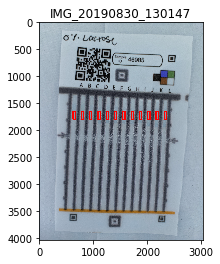

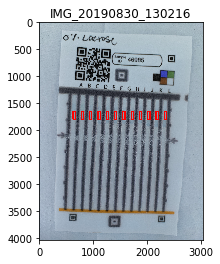

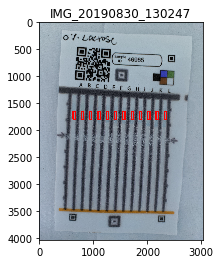

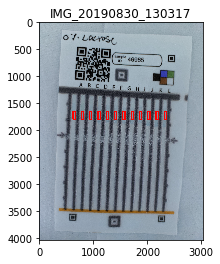

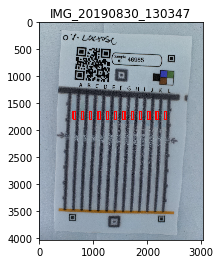

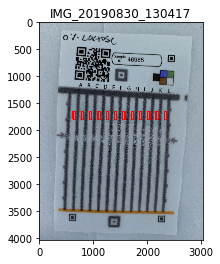

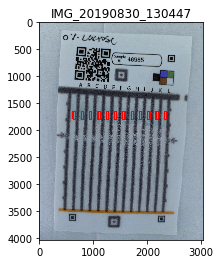

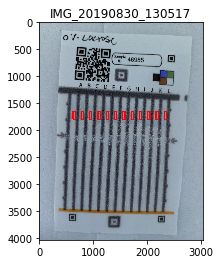

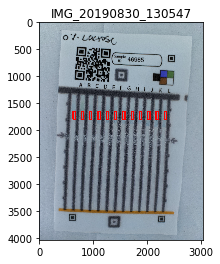

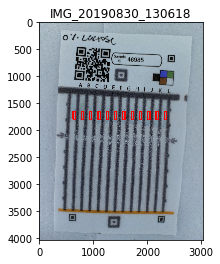

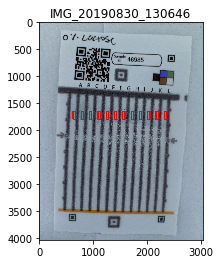

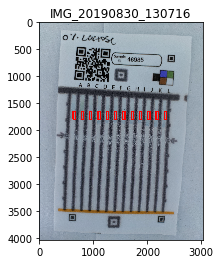

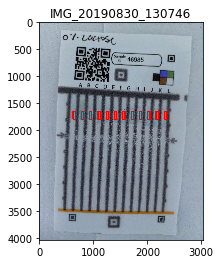

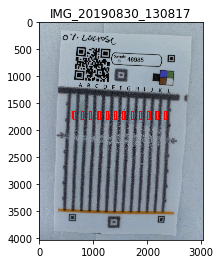

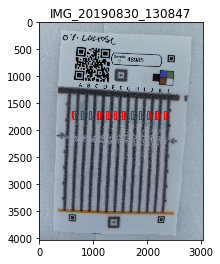

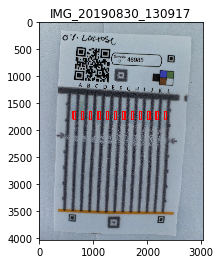

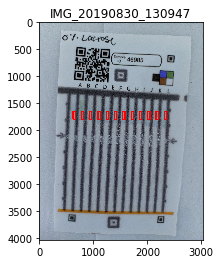

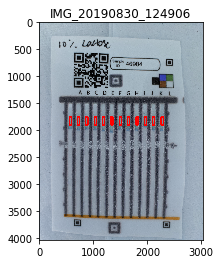

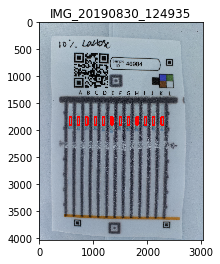

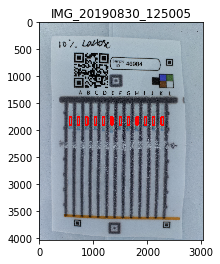

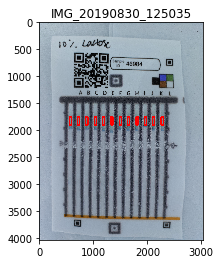

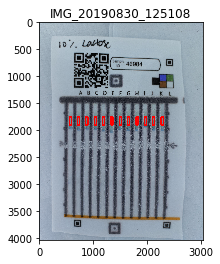

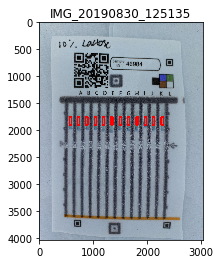

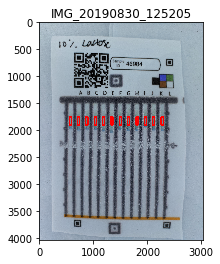

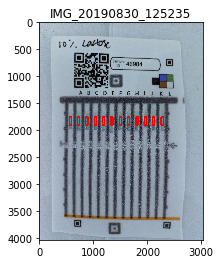

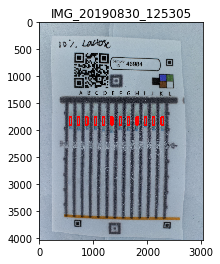

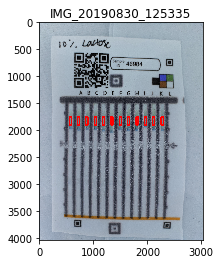

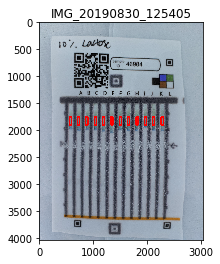

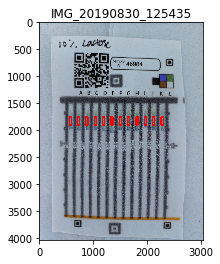

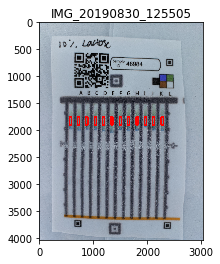

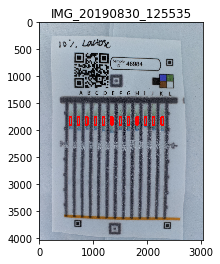

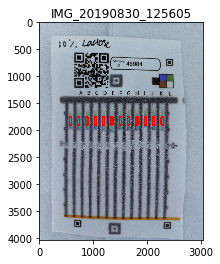

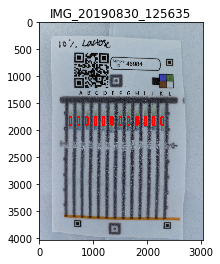

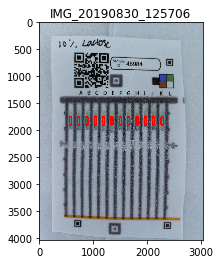

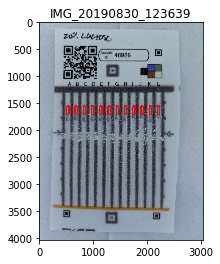

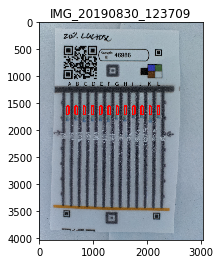

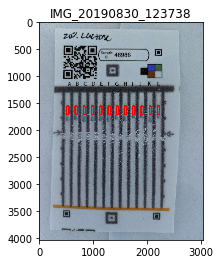

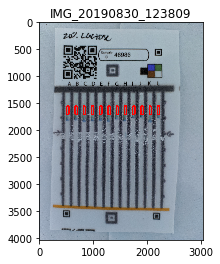

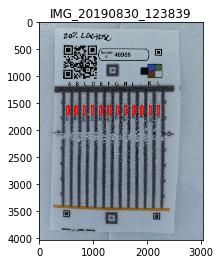

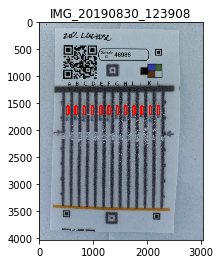

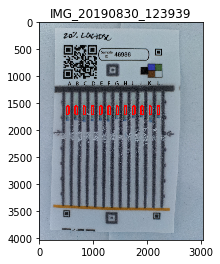

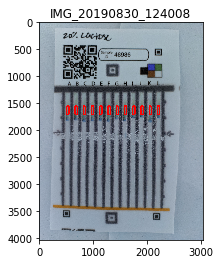

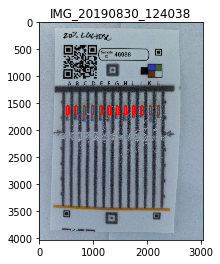

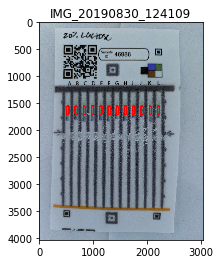

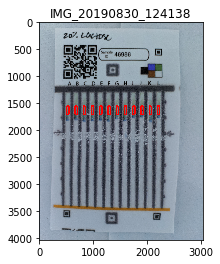

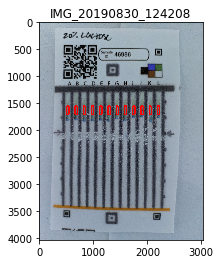

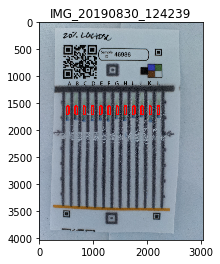

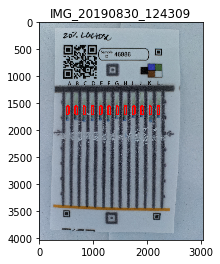

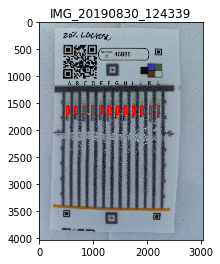

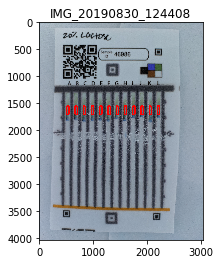

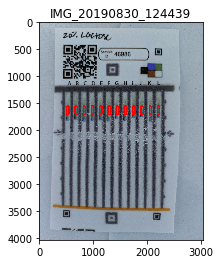

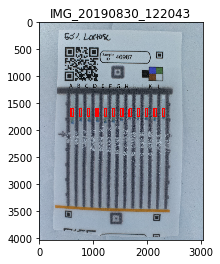

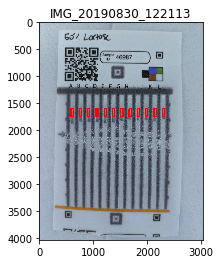

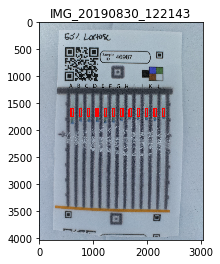

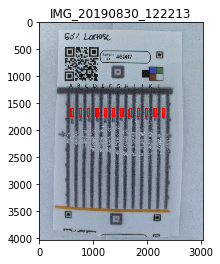

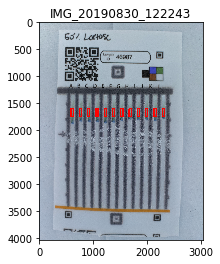

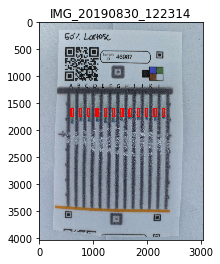

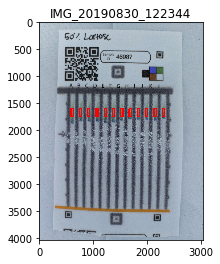

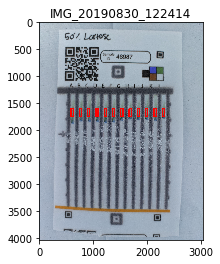

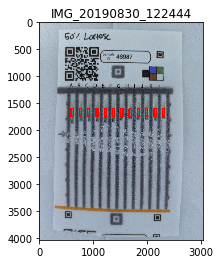

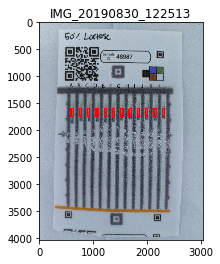

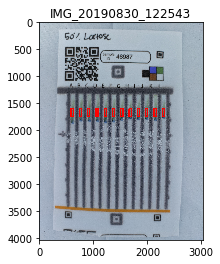

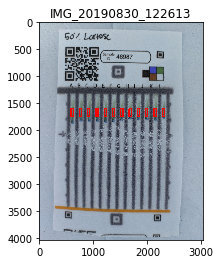

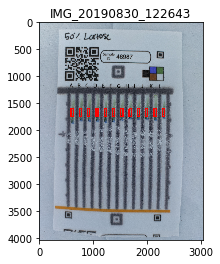

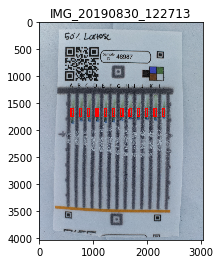

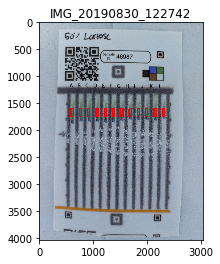

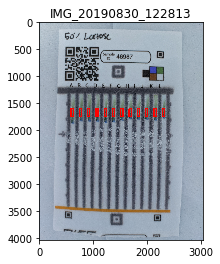

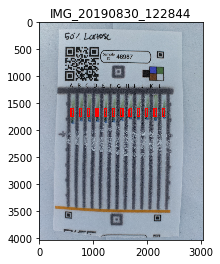

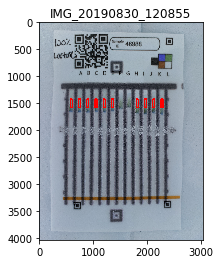

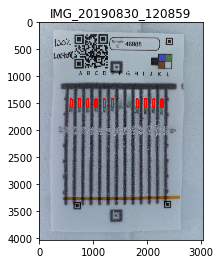

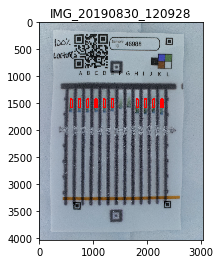

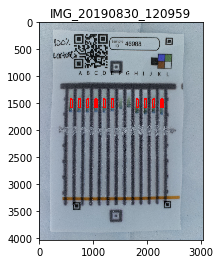

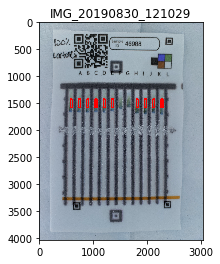

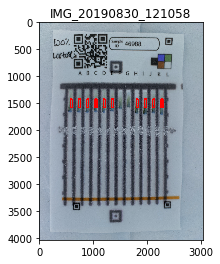

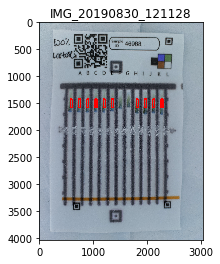

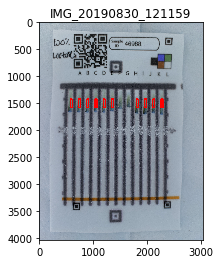

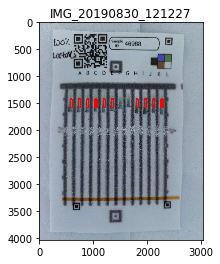

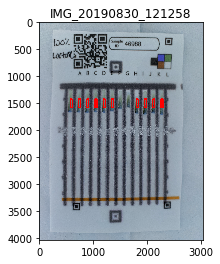

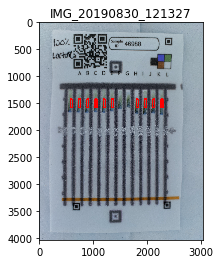

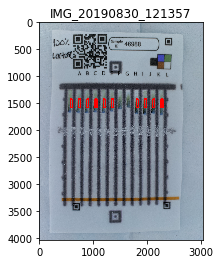

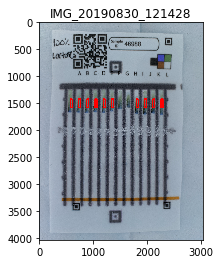

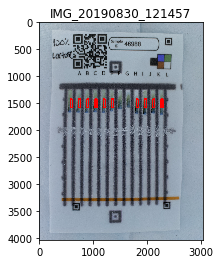

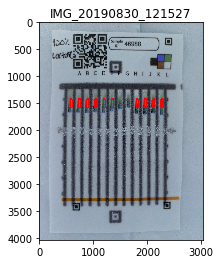

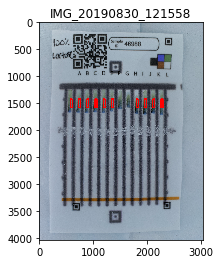

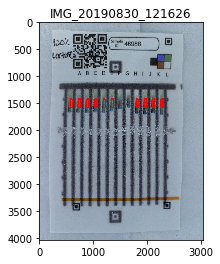

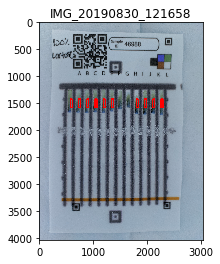

In [19]:
for directory_object in input_directory_objects:
    directory_object.column_data, directory_object.summary_data = sample_directory_and_create_output_data(
        directory_object.image_filenames,
        OUTPUT_DIRECTORY,
        directory_object.box_settings,
        verbose=False,
        draw=True,
        name_for_super_duper_hack=directory_object.name
    )

## Export to CSV

In [20]:
def create_column_data_frame(
    column_data,
    every_other_lane=False
):
    column_df = pd.DataFrame(column_data)
    column_df["TimeDelta"] = column_df["Time"] - column_df["Time"].min()
    column_df["TimeDelta"] = column_df["TimeDelta"].astype('timedelta64[s]')
    column_df = column_df[[
        "Filename",
        "Column",
        "TopLeftX",
        "TopLeftY",
        "BottomRightX",
        "BottomRightY",
        "AverageBlue",
        "AverageGreen",
        "AverageRed",
        "AverageInvertedBlue",
        "AverageInvertedGreen",
        "AverageInvertedRed",
        "GrayscaleIntensity",
        "InvertedGrayscaleIntensity",
        "Date",
        "Time",
        "Datetime",
        "TimeDelta" 
    ]]
    if every_other_lane:
        column_df = column_df.loc[column_df["Column"].isin([0, 2, 4, 6, 8, 10])]
    return column_df

In [21]:
def create_summary_data_frame(
    summary_data
):
    summary_df = pd.DataFrame(summary_data)
    summary_df["TimeDelta"] = summary_df["Time"] - summary_df["Time"].min()
    summary_df["TimeDelta"] = summary_df["TimeDelta"].astype('timedelta64[s]')
    summary_df = summary_df[[
        "Filename",

        "BlueMean",
        "BlueStd",
        "BlueMin",
        "Blue25%",
        "Blue50%",
        "Blue75%",
        "BlueMax",
        "GreenMean",
        "GreenStd",
        "GreenMin",
        "Green25%",
        "Green50%",
        "Green75%",
        "GreenMax",
        "RedMean",
        "RedStd",
        "RedMin",
        "Red25%",
        "Red50%",
        "Red75%",
        "RedMax",

        "InvertedBlueMean",
        "InvertedBlueStd",
        "InvertedBlueMin",
        "InvertedBlue25%",
        "InvertedBlue50%",
        "InvertedBlue75%",
        "InvertedBlueMax",

        "InvertedGreenMean",
        "InvertedGreenStd",
        "InvertedGreenMin",
        "InvertedGreen25%",
        "InvertedGreen50%",
        "InvertedGreen75%",
        "InvertedGreenMax",

        "InvertedRedMean",
        "InvertedRedStd",
        "InvertedRedMin",
        "InvertedRed25%",
        "InvertedRed50%",
        "InvertedRed75%",
        "InvertedRedMax",

        "GrayscaleIntensityMean",
        "GrayscaleIntensityStd",
        "GrayscaleIntensityMin",
        "GrayscaleIntensity25%",
        "GrayscaleIntensity50%",
        "GrayscaleIntensity75%",
        "GrayscaleIntensityMax",

        "InvertedGrayscaleIntensityMean",
        "InvertedGrayscaleIntensityStd",
        "InvertedGrayscaleIntensityMin",
        "InvertedGrayscaleIntensity25%",
        "InvertedGrayscaleIntensity50%",
        "InvertedGrayscaleIntensity75%",
        "InvertedGrayscaleIntensityMax",

        "Date",
        "Time",
        "Datetime",
        "TimeDelta"
    ]]
    return summary_df

In [22]:
for directory_object in input_directory_objects:
    directory_object.column_data_frame = create_column_data_frame(directory_object.column_data)
    directory_object.summary_data_frame = create_summary_data_frame(directory_object.summary_data)

## Plot Color Changes Over Time

Just a cute little sample of what we have.

In [23]:
input_directory_objects[0].summary_data_frame.head()

Filename    BlueMean   BlueStd  \
0  C:\Users\ericc\projects\padtools\raw_images\20...  133.125222  4.517746   
1  C:\Users\ericc\projects\padtools\raw_images\20...  132.783097  4.722742   
2  C:\Users\ericc\projects\padtools\raw_images\20...  125.094042  4.983725   
3  C:\Users\ericc\projects\padtools\raw_images\20...  124.852833  5.074898   
4  C:\Users\ericc\projects\padtools\raw_images\20...  124.709153  5.039036   

      BlueMin     Blue25%     Blue50%     Blue75%     BlueMax   GreenMean  \
0  122.487167  131.439667  134.368417  136.263417  138.582500  153.021514   
1  121.020000  130.894417  133.883917  136.133625  138.091000  152.999306   
2  112.537333  123.861667  126.851500  127.799500  130.849833  144.499667   
3  111.988500  123.510042  126.543667  127.670042  130.455167  144.406097   
4  111.299500  124.217958  126.108500  127.116250  129.700333  144.375417   

   GreenStd  ...  InvertedGrayscaleIntensityStd  \
0  3.624517  ...                       3.757895   
1  3.542381  ...                       3.798227   
2  3.582970  ...                       3.895640   
3  3.606799  ...                       3.977254   
4  3.810332  ...                       4.120980   

   InvertedGrayscaleIntensityMin  InvertedGrayscaleIntensity25%  \
0                      99.628000                     101.352153   
1                      99.669667                     101.777875   
2                     107.961556                     110.690625   
3                     107.833111                     110.976042   
4                     108.355944                     110.577931   

   InvertedGrayscaleIntensity50%  InvertedGrayscaleIntensity75%  \
0                     102.939583                     104.640708   
1                     103.537278                     104.818000   
2                     111.719639                     113.625236   
3                     111.737472                     113.621889   
4                     111.924944                     115.086667   

   InvertedGrayscaleIntensityMax       Date                Time  \
0                     112.804167 2019-08-30 1900-01-01 13:01:47   
1                     113.476222 2019-08-30 1900-01-01 13:02:16   
2                     122.155611 2019-08-30 1900-01-01 13:02:47   
3                     122.451833 2019-08-30 1900-01-01 13:03:17   
4                     123.317778 2019-08-30 1900-01-01 13:03:47   

             Datetime  TimeDelta  
0 2019-08-30 13:01:47        0.0  
1 2019-08-30 13:02:16       29.0  
2 2019-08-30 13:02:47       60.0  
3 2019-08-30 13:03:17       90.0  
4 2019-08-30 13:03:47      120.0  

[5 rows x 61 columns]

In [24]:
def plot_colors_over_time(
    summary_df,
    title=None,
    save=False,
    output_dir="."
):
    if title:
        title += " Average Color Change Over Time"
    else:
        title = "Average Color Change Over Time"
    fig, ax = plt.subplots();

    summary_df.plot(ax=ax, x="TimeDelta", y="BlueMean", yerr="BlueStd", capsize=3, color="blue");
    summary_df.plot(ax=ax, x="TimeDelta", y="RedMean", yerr="RedStd", capsize=3, color="red");
    summary_df.plot(ax=ax, x="TimeDelta", y="GreenMean", yerr="GreenStd", capsize=3, color="green");
    ax.set_title(title);
    ax.set_ylabel("Intensity (0 - 255)");
    ax.set_xlabel("Time (s)");
    ax.set_xlim(
        summary_df.iloc[0]["TimeDelta"] - PADDING_USED_ON_SIDES_OF_PLOTS,
        summary_df.iloc[-1]["TimeDelta"] + PADDING_USED_ON_SIDES_OF_PLOTS
    );
    ax.legend(["Blue Mean", "Red Mean", "Green Mean"]);
    if save:
        leaf = title.lower().replace(" ", "_").replace("%", "") + ".png"
        filename = output_dir / leaf
        fig.savefig(str(filename))

In [25]:
def plot_inverted_colors_over_time(
    summary_df,
    title=None,
    save=False,
    output_dir="."
):
    if title:
        title += " Average Inverted Color Change Over Time"
    else:
        title = "Average Inverted Color Change Over Time"
    fig, ax = plt.subplots();
    summary_df.plot(ax=ax, x="TimeDelta", y="InvertedBlueMean", yerr="InvertedBlueStd", capsize=3, color="blue");
    summary_df.plot(ax=ax, x="TimeDelta", y="InvertedRedMean", yerr="InvertedRedStd", capsize=3, color="red");
    summary_df.plot(ax=ax, x="TimeDelta", y="InvertedGreenMean", yerr="InvertedGreenStd", capsize=3, color="green");
    ax.set_title(title);
    ax.set_ylabel("Intensity (0 - 255)");
    ax.set_xlabel("Time (s)");
    ax.set_xlim(
        summary_df.iloc[0]["TimeDelta"] - PADDING_USED_ON_SIDES_OF_PLOTS,
        summary_df.iloc[-1]["TimeDelta"] + PADDING_USED_ON_SIDES_OF_PLOTS
    );
    ax.legend(["Inverted Blue Mean", "Inverted Red Mean", "Inverted Green Mean"]); 
    if save:
        leaf = title.lower().replace(" ", "_").replace("%", "") + ".png"
        filename = output_dir / leaf
        fig.savefig(str(filename))

In [26]:
def plot_grayscale_over_time(
    summary_df,
    title=None,
    save=False,
    output_dir="."
):
    if title:
        title += " Average Grayscale Intensity Over Time"
    else:
        title = "Average Grayscale Intensity Over Time"
    fig, ax = plt.subplots();
    summary_df.plot(
        ax=ax,
        x="TimeDelta",
        y="GrayscaleIntensityMean",
        yerr="GrayscaleIntensityStd",
        capsize=3,
        color="gray",
        legend=False
    );
    ax.set_title(title);
    ax.set_ylabel("Intensity (0 - 255)");
    ax.set_xlabel("Time (s)");
    ax.set_xlim(
        summary_df.iloc[0]["TimeDelta"] - PADDING_USED_ON_SIDES_OF_PLOTS,
        summary_df.iloc[-1]["TimeDelta"] + PADDING_USED_ON_SIDES_OF_PLOTS
    );
    if save:
        leaf = title.lower().replace(" ", "_").replace("%", "") + ".png"
        filename = output_dir / leaf
        fig.savefig(str(filename))

In [27]:
def plot_inverted_grayscale_over_time(
    summary_df,
    title=None,
    save=False,
    output_dir="."
):
    if title:
        title += " Average Inverted Grayscale Intensity Over Time"
    else:
        title = "Average Inverted Grayscale Intensity Over Time"
    fig, ax = plt.subplots();
    summary_df.plot(
        ax=ax,
        x="TimeDelta",
        y="InvertedGrayscaleIntensityMean",
        yerr="InvertedGrayscaleIntensityStd",
        capsize=3,
        color="gray",
        legend=False
    );
    ax.set_title(title);
    ax.set_ylabel("Intensity (0 - 255)");
    ax.set_xlabel("Time (s)");
    ax.set_xlim(
        summary_df.iloc[0]["TimeDelta"] - PADDING_USED_ON_SIDES_OF_PLOTS,
        summary_df.iloc[-1]["TimeDelta"] + PADDING_USED_ON_SIDES_OF_PLOTS
    );
    if save:
        leaf = title.lower().replace(" ", "_").replace("%", "") + ".png"
        filename = output_dir / leaf
        fig.savefig(str(filename))

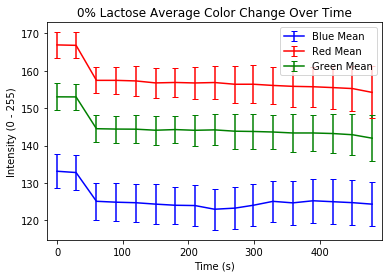

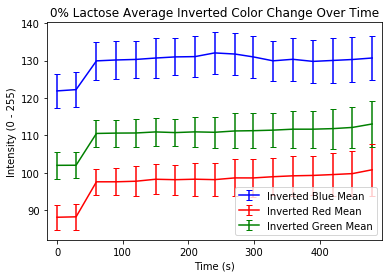

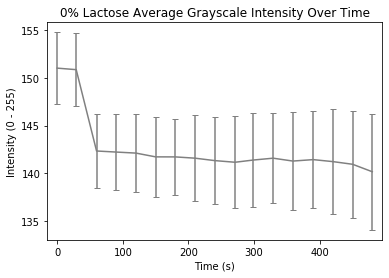

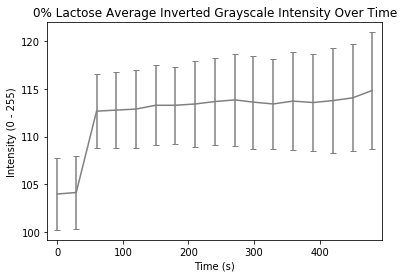

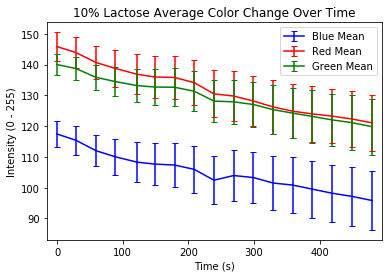

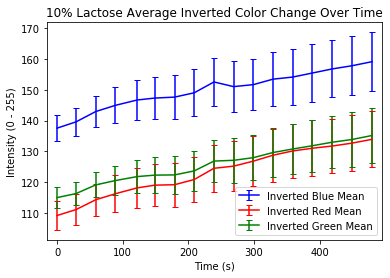

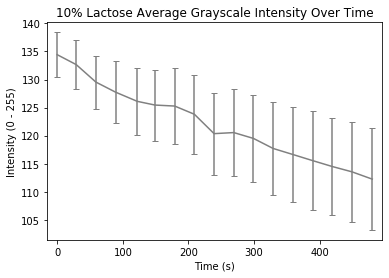

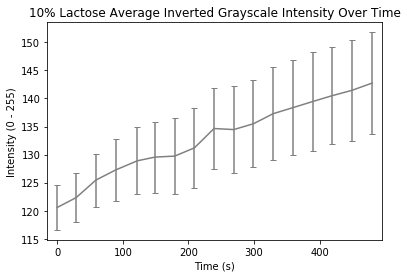

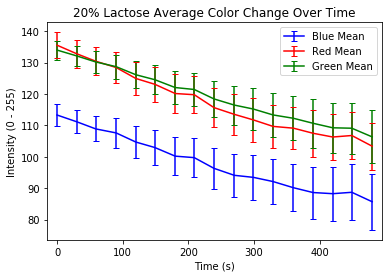

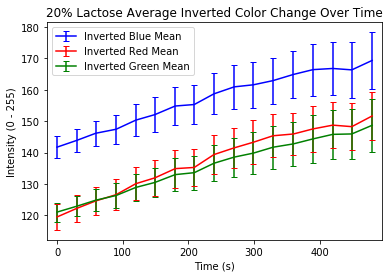

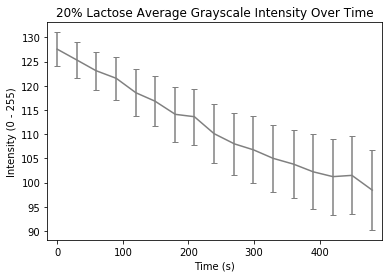

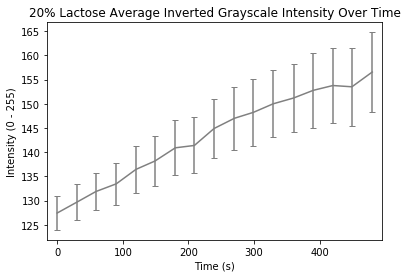

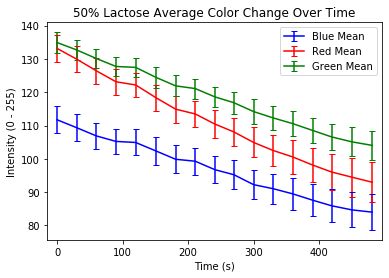

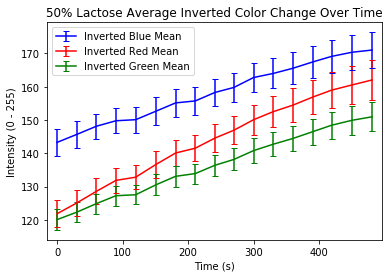

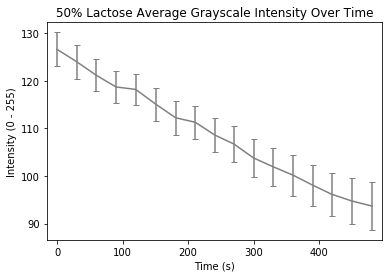

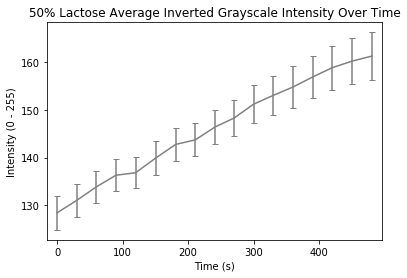

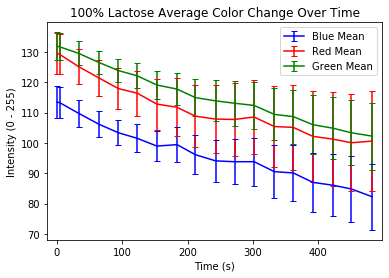

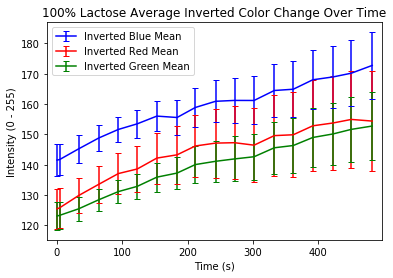

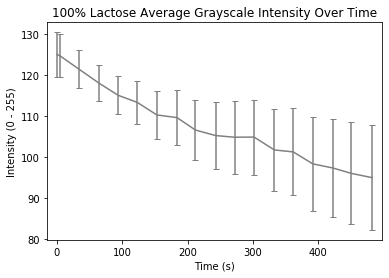

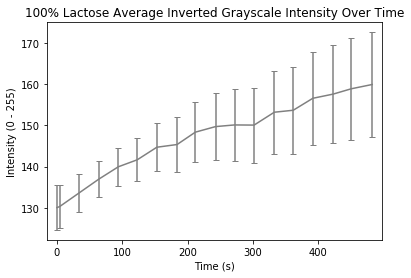

In [28]:
for directory_object in input_directory_objects:
    plot_colors_over_time(
        directory_object.summary_data_frame,
        title=directory_object.name,
        save=True,
        output_dir=output_dir
    )
    plot_inverted_colors_over_time(
        directory_object.summary_data_frame,
        title=directory_object.name,
        save=True,
        output_dir=output_dir
    )
    plot_grayscale_over_time(
        directory_object.summary_data_frame,
        title=directory_object.name,
        save=True,
        output_dir=output_dir
    )
    plot_inverted_grayscale_over_time(
        directory_object.summary_data_frame,
        title=directory_object.name,
        save=True,
        output_dir=output_dir
    )

In [29]:
def plot_many_inverted_grayscale_intensities_over_time(
    summary_dfs,
    names,
    save=False,
    output_dir="."
):
    overall_title = "Average Inverted Grayscale Intensity Over Time"
    fig, ax = plt.subplots();
    for summary_df, legend_name in zip(summary_dfs, names):
        summary_df.plot(
            ax=ax,
            x="TimeDelta",
            y="InvertedGrayscaleIntensityMean",
            yerr="InvertedGrayscaleIntensityStd",
            capsize=3,
            label=legend_name
        );
    ax.set_title(overall_title);
    ax.set_ylabel("Intensity (0 - 255)");
    ax.set_xlabel("Time (s)");
    ax.set_xlim(
        summary_df.iloc[0]["TimeDelta"] - PADDING_USED_ON_SIDES_OF_PLOTS,
        summary_df.iloc[-1]["TimeDelta"] + PADDING_USED_ON_SIDES_OF_PLOTS
    );
    if save:
        leaf = overall_title.lower().replace(" ", "_").replace("%", "") + ".png"
        filename = output_dir / leaf
        fig.savefig(str(filename))    

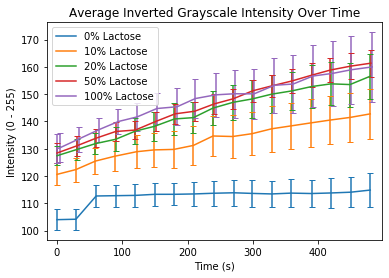

In [30]:
plot_many_inverted_grayscale_intensities_over_time(
    [x.summary_data_frame for x in input_directory_objects],
    [x.name for x in input_directory_objects],
    save=True,
    output_dir=output_dir
)

## Save Data as CSV

In [31]:
for directory_object in input_directory_objects:
    directory_object.save_data_frames_to_csv(output_dir=OUTPUT_DIRECTORY)

Saving 0% Lactose data frames to C:\Users\ericc\projects\padtools\output.
Saved C:\Users\ericc\projects\padtools\output\0_lactose_columns.csv.
Saved C:\Users\ericc\projects\padtools\output\0_lactose_summary.csv.
Saving 10% Lactose data frames to C:\Users\ericc\projects\padtools\output.
Saved C:\Users\ericc\projects\padtools\output\10_lactose_columns.csv.
Saved C:\Users\ericc\projects\padtools\output\10_lactose_summary.csv.
Saving 20% Lactose data frames to C:\Users\ericc\projects\padtools\output.
Saved C:\Users\ericc\projects\padtools\output\20_lactose_columns.csv.
Saved C:\Users\ericc\projects\padtools\output\20_lactose_summary.csv.
Saving 50% Lactose data frames to C:\Users\ericc\projects\padtools\output.
Saved C:\Users\ericc\projects\padtools\output\50_lactose_columns.csv.
Saved C:\Users\ericc\projects\padtools\output\50_lactose_summary.csv.
Saving 100% Lactose data frames to C:\Users\ericc\projects\padtools\output.
Saved C:\Users\ericc\projects\padtools\output\100_lactose_columns.c